### NN

In [3]:
from fastai.tabular.all import *

In [27]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()


(#3) [Path('/data/gpfs-1/users/nazaretl_c/.fastai/data/adult_sample/adult.csv'),Path('/data/gpfs-1/users/nazaretl_c/.fastai/data/adult_sample/models'),Path('/data/gpfs-1/users/nazaretl_c/.fastai/data/adult_sample/export.pkl')]

In [29]:
df = pd.read_csv(path/'adult.csv')


In [30]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

In [31]:
cat = Categorify()

In [38]:
to = TabularPandas(df, cat, cat_names)
cats = to.procs.categorify
norm = Normalize()
to = TabularPandas(df, norm, cont_names=cont_names)
norms = to.procs.normalize
fm = FillMissing(fill_strategy=FillStrategy.median)
to = TabularPandas(df, fm, cont_names=cont_names)


In [46]:
splits = RandomSplitter()(range_of(df))
range_of(df)[:5], len(df)
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()

to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)
dls = to.dataloaders()
trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)
dls = DataLoaders(trn_dl, val_dl)
#dls.show_batch()



In [51]:
emb_szs = get_emb_sz(to); emb_szs
cont_len = len(to.cont_names); cont_len
batch = dls.one_batch(); len(batch)
batch[0][0], batch[1][0]
net = TabularModel(emb_szs, cont_len, 2, [200,100])


In [52]:
net


TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=42, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [53]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)


SuggestedLRs(valley=0.002511886414140463)

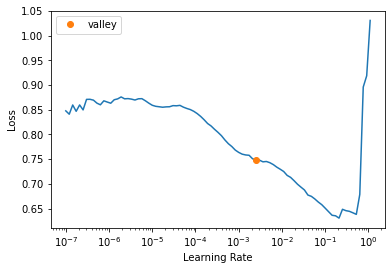

In [54]:
learn.lr_find()


In [55]:
learn.fit(3, 1e-2)


epoch,train_loss,valid_loss,accuracy,time
0,0.368044,0.363505,0.832924,00:02
1,0.362916,0.366420,0.824785,00:02
2,0.353394,0.367633,0.834920,00:02


In [56]:
dls = to.dataloaders(bs=1024)
learn = tabular_learner(dls, [200,100], metrics=accuracy)
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.502093,0.441566,0.779177,00:00
1,0.413410,0.360143,0.834459,00:00
2,0.381774,0.359614,0.833845,00:00


In [57]:
row, cls, probs = learn.predict(df.iloc[0])


In [58]:
dl = learn.dls.test_dl(df.iloc[:100])


In [59]:
learn.validate(dl=dl)


(#2) [0.41388294100761414,0.8100000023841858]

In [62]:
preds = learn.get_preds(dl=dl)


In [64]:
df2 = df.iloc[:100].drop('salary', axis=1)
df2.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States


In [65]:
dl = learn.dls.test_dl(df2)
learn.validate(dl=dl)


(#2) [None,None]

### Autoencoder

In [1]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')


In [2]:
# Next we'll want our cat_names, cont_names, procs, etc:

cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()
splits = RandomSplitter()(range_of(df))

# And finally we'll get a baseline accuracy:

to = TabularPandas(df, procs = [Categorify, FillMissing, Normalize], cat_names=cat_names, cont_names=cont_names, 
                   splits=splits, y_names=['salary'], y_block=CategoryBlock())

dls = to.dataloaders(bs=1024)
learn = tabular_learner(dls, layers=[200,100], metrics=[accuracy])
learn.fit(5, 1e-2)




epoch,train_loss,valid_loss,accuracy,time
0,0.536857,0.467038,0.767199,00:00
1,0.427249,0.344879,0.842138,00:00
2,0.389015,0.345246,0.841830,00:00
3,0.371726,0.343546,0.843673,00:00
4,0.361485,0.344698,0.843366,00:00


In [6]:
## if after throws an error


In [3]:
## if after throws an error
#TabularPandasIdentity._dl_type = TabDataLoaderIdentity

class ReadTabBatchIdentity(ItemTransform):
    "Read a batch of data and return the inputs as both `x` and `y`"
    def __init__(self, to): store_attr()

    def encodes(self, to):
        if not to.with_cont: res = (tensor(to.cats).long(),) + (tensor(to.cats).long(),)
        else: res = (tensor(to.cats).long(),tensor(to.conts).float()) + (tensor(to.cats).long(), tensor(to.conts).float())
        if to.device is not None: res = to_device(res, to.device)
        return res
    
class TabularPandasIdentity(TabularPandas): pass


@delegates()
class TabDataLoaderIdentity(TabDataLoader):
    "A transformed `DataLoader` for AutoEncoder problems with Tabular data"
    do_item = noops
    def __init__(self, dataset, bs=16, shuffle=False, after_batch=None, num_workers=0, **kwargs):
        if after_batch is None: after_batch = L(TransformBlock().batch_tfms)+ReadTabBatchIdentity(dataset)
        super().__init__(dataset, bs=bs, shuffle=shuffle, after_batch=after_batch, num_workers=num_workers, **kwargs)

    def create_batch(self, b): return self.dataset.iloc[b]
    
    
    
class RecreatedLoss(Module):
    "Measures how well we have created the original tabular inputs"
    def __init__(self, cat_dict):
        ce = CrossEntropyLossFlat(reduction='sum')
        mse = MSELossFlat(reduction='sum')
        store_attr('cat_dict,ce,mse')

    def forward(self, preds, cat_targs, cont_targs):
        cats, conts = preds
        tot_ce, pos = cats.new([0]), 0
        for i, (k,v) in enumerate(self.cat_dict.items()):
            tot_ce += self.ce(cats[:, pos:pos+v], cat_targs[:,i])
            pos += v
        
        norm_cats = cats.new([len(self.cat_dict)])
        norm_conts = conts.new([conts.size(1)])
        cat_loss = tot_ce/norm_cats
        cont_loss = self.mse(conts, cont_targs)/norm_conts
        total = cat_loss+cont_loss

        return total / cats.size(0)

In [36]:
targs

NameError: name 'targs' is not defined

In [4]:
TabularPandasIdentity._dl_type = TabDataLoaderIdentity
to = TabularPandasIdentity(df, [Categorify, FillMissing, Normalize], cat_names, cont_names, splits=RandomSplitter(seed=32)(df))


In [5]:
dls = to.dataloaders(bs=1024)



In [6]:
dls.n_inp = 2


In [19]:
total_cats = {k:len(v) for k,v in to.classes.items()}
total_cats

{'workclass': 10,
 'education': 17,
 'marital-status': 8,
 'occupation': 16,
 'relationship': 7,
 'race': 6,
 'education-num_na': 3}

In [20]:
sum([v for k,v in total_cats.items()])


67

In [21]:
means = pd.DataFrame.from_dict({k:[v] for k,v in to.means.items()})
stds = pd.DataFrame.from_dict({k:[v] for k,v in to.stds.items()})

In [22]:
low = (df[cont_names].min().to_frame().T.values - means.values) / stds.values
high = (df[cont_names].max().to_frame().T.values - means.values) / stds.values


In [23]:
loss_func = RecreatedLoss(total_cats)


In [24]:
class BatchSwapNoise(Module):
    "Swap Noise Module"
    def __init__(self, p): store_attr()

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size()) > (1 - self.p)
            l1 = torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor)
            l2 = (mask.type(torch.LongTensor) * x.size(1))
            res = (l1 * l2).view(-1)
            idx = torch.arange(x.nelement()) + res
            idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
            return x.flatten()[idx].view(x.size())
        else:
            return x
        
class TabularAE(TabularModel):
    "A simple AutoEncoder model"
    def __init__(self, emb_szs, n_cont, hidden_size, cats, low, high, ps=0.2, embed_p=0.01, bswap=None):
        super().__init__(emb_szs, n_cont, layers=[1024, 512, 256], out_sz=hidden_size, embed_p=embed_p, act_cls=Mish())
        
        self.bswap = bswap
        self.cats = cats
        self.activation_cats = sum([v for k,v in cats.items()])
        
        self.layers = nn.Sequential(*L(self.layers.children())[:-1] + nn.Sequential(LinBnDrop(256, hidden_size, p=ps, act=Mish())))
        
        if(bswap != None): self.noise = BatchSwapNoise(bswap)
        self.decoder = nn.Sequential(
            LinBnDrop(hidden_size, 256, p=ps, act=Mish()),
            LinBnDrop(256, 512, p=ps, act=Mish()),
            LinBnDrop(512, 1024, p=ps, act=Mish())
        )
        
        self.decoder_cont = nn.Sequential(
            LinBnDrop(1024, n_cont, p=ps, bn=False, act=None),
            SigmoidRange(low=low, high=high)
        )
        
        self.decoder_cat = LinBnDrop(1024, self.activation_cats, p=ps, bn=False, act=None)
        
    def forward(self, x_cat, x_cont=None, encode=False):
        if(self.bswap != None):
            x_cat = self.noise(x_cat)
            x_cont = self.noise(x_cont)
        encoded = super().forward(x_cat, x_cont)
        if encode: return encoded # return the representation
        decoded_trunk = self.decoder(encoded)
        decoded_cats = self.decoder_cat(decoded_trunk)
        decoded_conts = self.decoder_cont(decoded_trunk)
        return decoded_cats, decoded_conts
    

In [25]:
emb_szs = get_emb_sz(to.train)


In [31]:
dl = learn.dls.test_dl(df)

(cat_preds, cont_preds), (cat_targs, cont_targs) = learn.get_preds(dl=dl)

cont_preds = pd.DataFrame(cont_preds, columns=cont_names)
cont_targs = pd.DataFrame(cont_targs, columns=cont_names)


TypeError: RecreatedLoss.forward() missing 1 required positional argument: 'cont_targs'

In [32]:
model = TabularAE(emb_szs, len(cont_names), 128, ps=0.1, cats=total_cats, embed_p=0.01,
                  bswap=.1, low=tensor(low), high=tensor(high))


In [33]:
learn = Learner(dls, model, loss_func=loss_func, wd=0.01, opt_func=ranger)


In [34]:
learn.fit_flat_cos(100, cbs=[EarlyStoppingCallback()], lr=4e-3)
#learn.fit(100, cbs=[EarlyStoppingCallback()], lr=4e-3)


epoch,train_loss,valid_loss,time


TypeError: RecreatedLoss.forward() missing 1 required positional argument: 'cont_targs'

In [1]:
from wwf.utils import *
state_versions(['fastai', 'fastcore'])

ModuleNotFoundError: No module named 'wwf'